# Poisson Switching Linear Dynamical Systems (SLDS) Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindermanlab/ssm-jax-refactor/blob/main/notebooks/poisson-slds-example.ipynb)


# 1. Setup

We import `jax` and `ssm`, as well as some plotting utils.

In [1]:
import jax.numpy as np
import jax.random as jr

from ssm.utils import random_rotation
from ssm.slds.models import PoissonSLDS
from ssm.plots import gradient_cmap

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple"
]


colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# 2. Creating an SLDS and sampling from it

In [2]:
# First, specify hyperparameters
num_states = 5
latent_dim = 2
data_dim = 10
num_timesteps = 10000

## Set the initial state probabilities

In [3]:
initial_state_probs = np.ones(num_states) / num_states
initial_state_mean = np.zeros((latent_dim))
initial_state_scale_tril = np.eye(latent_dim)

## Make a transition matrix

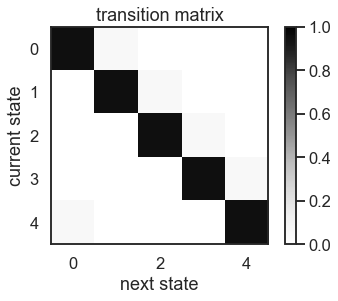

In [4]:
transition_probs = (np.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = np.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += np.roll(p * np.eye(num_states), k, axis=1)
    
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()

## Make simple linear dynamics for each state.

These dynamics rotate and converge to a fixed point at a specified location around the unit circle.

We call these **starfish dynamics** for reasons that will become obvious in a second.

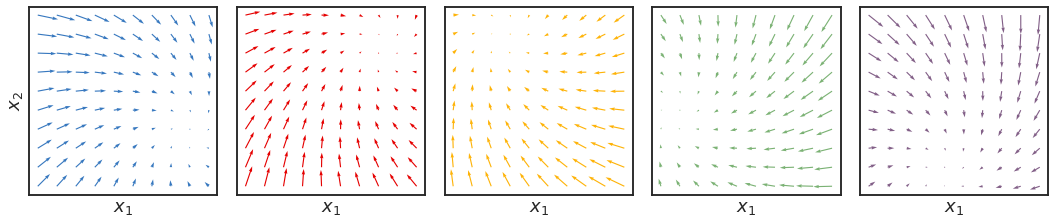

In [5]:
keys = jr.split(jr.PRNGKey(0), num_states)
theta = np.pi / 25 # rotational frequency
angles = np.linspace(0, 2 * np.pi, num_states, endpoint=False)
biases = np.column_stack([np.cos(angles), np.sin(angles), np.zeros((num_states, latent_dim - 2))])
dynamics_weights = np.array([0.8 * random_rotation(key, latent_dim, theta=theta) for key in keys])
dynamics_biases = np.column_stack([np.cos(angles), np.sin(angles), np.zeros((num_states, latent_dim - 2))])
dynamics_scale_trils = np.tile(np.sqrt(0.001) * np.eye(latent_dim), (num_states, 1, 1))

# Plot the dynamics
if latent_dim == 2:
    lim = 5
    x = np.linspace(-lim, lim, 10)
    y = np.linspace(-lim, lim, 10)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
    for k in range(num_states):
        A, b = dynamics_weights[k], dynamics_biases[k]
        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                    dxydt_m[:, 0], dxydt_m[:, 1],
                    color=colors[k % len(colors)])

        
        axs[k].set_xlabel('$x_1$')
        axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel("$x_2$")
        axs[k].set_yticks([])
        axs[k].set_aspect("equal")
                        

    plt.tight_layout()

## Set the emissions parameters

In this model, the emissions weights and biases will be the same for all discrete states.

Under this model, the true latent states have marginal variance of about $\sigma^2 = 7$ along each of the two dimensions. 
Under a simple model $x \sim \mathcal{N}(0, 7 I_2)$ we would expect that marginally $\log y_n \sim \mathcal{N}(d_n, c_n^\top (\sigma^2 I_2) c_n)$ where $c_n$ is the $n$-th row of the emission matrix and $d_n$ is the corresponding bias.
Since the entries of the emission matrix are standard normal variables, we have $\|c_n\|_2^2 \sim \chi^2(D)$, where $D$ is the latent state dimension. The mean of the chi-squared distribution is $D$, so we have that approximately $\log y_n \sim \mathcal{N}(d_n, \sigma^2 D)$.
When we exponentiate, we get that $\mathbb{E}[y_n] = \exp\{d_n + \sigma^2 D / 2\}$.

We will set the bias so that the expected spike count is around 1, which means $d_n = -\sigma^2 D / 2$. 

In [19]:
emissions_weights = np.tile(jr.normal(jr.PRNGKey(1), (data_dim, latent_dim)), (num_states, 1, 1))
emissions_biases = np.ones((num_states, data_dim))

## Construct the Poisson SLDS

In [20]:
slds = PoissonSLDS(num_states,
                   latent_dim,
                   data_dim,
                   initial_state_probs,
                   initial_state_mean,
                   initial_state_scale_tril,
                   transition_matrix,
                   dynamics_weights,
                   dynamics_biases,
                   dynamics_scale_trils,
                   emissions_weights,
                   emissions_biases)

## Sample data from the SLDS.

Note that the states that come out are a dictionary with `continuous` and `discrete` keys.

In [21]:
true_states, data = slds.sample(jr.PRNGKey(3), num_timesteps)
true_x = true_states["continuous"]
true_z = true_states["discrete"]


/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3070: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/Users/scott/miniconda3/en

## Plot the latent states

We plot the continuous latent state trajectory $x_1, \ldots, x_T$, color-coded by the corresponding discrete state $z_t$. See why we call these starfish dynamics?

Text(0, 0.5, '$x_2$')

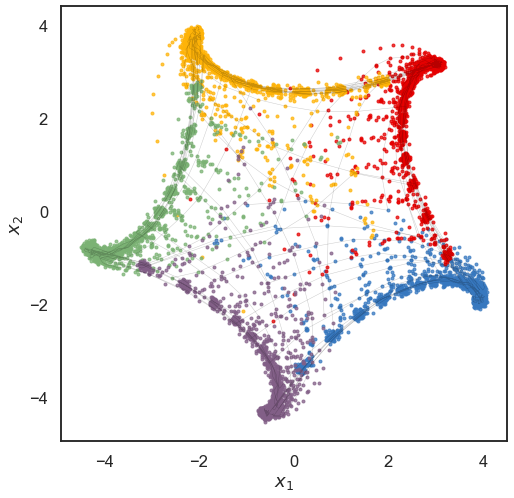

In [22]:
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*true_x[true_z==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*true_x[:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

## Plot the data

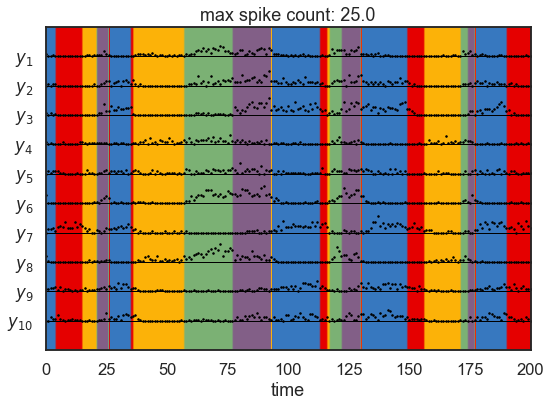

In [42]:
plot_slice = (0, 200)
plt.figure(figsize=(8, 6))
lim = 1 * abs(data).max()
plt.imshow(true_z[None, :],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, num_timesteps, -(data_dim)*lim, lim))


for d in range(data_dim):
    plt.plot(np.zeros(num_timesteps) - lim * d, '-k', lw=1)
    plt.plot(data[:,d] - lim * d, 'k.', ms=3)

plt.xlim(plot_slice)
plt.xlabel("time")
plt.yticks(-lim * np.arange(data_dim), ["$y_{{{}}}$".format(d+1) for d in range(data_dim)])
plt.title("max spike count: {}".format(data.max()))

plt.tight_layout()


## Evaluate the joint log probability under the model

In [31]:
slds.log_probability(true_states, data) / num_timesteps

DeviceArray(-9.126152, dtype=float32)

# 3. Fit an SLDS from the observed data

First make another `GaussianSLDS` object. Since we're fitting this one to data, we'll use a simpler constructor that just randomly initializes the parameters. All we have to do is give it the hyperparameters (number of discrete states, continuous state dimension, and the emission dimension) and a random number generator key.

In [32]:
test_slds = PoissonSLDS(num_states, latent_dim, data_dim, key=jr.PRNGKey(1))

## Fit the model!

We fit SLDS models with variational EM. This algorithm alternates between:

1. **Variational E step:** Approximate the posterior distribution over latent states by minimizing the Kullback-Leibler (KL) divergence to the true posterior,
\begin{align}
q(z, x) &= \arg \min_{\mathcal{Q}} D_{\mathrm{KL}}\left(q(z, x) \,\|\, p(z, x \mid y, \theta) \right)
\end{align}
We use a _structured mean field_ approximation, which takes the variational family $\mathcal{Q}$ to be
\begin{align}
\mathcal{Q} &= \left\{ q(z, x): q(z, x) = q(z_{1:T}) q(x_{1:T}) \right\}
\end{align}
For Gaussian SLDS, we can find a local minimizer of the KL divergence via coordinate descent.

2. **M-step:** Find parameters that maximize the _expected log probability_:
\begin{align}
\theta^\star &= \arg \max_\theta \mathbb{E}_{q(z,x)}\left[\log p(z, x, y \mid \theta)\right]
\end{align}

At each step of the algorithm, we compute the **evidence lower bound** or ELBO,
\begin{align}
\mathcal{L}(q, \theta) &= \mathbb{E}_{q(z,x)} \left[\log p(z, x, y \mid \theta) - \log q(z, x) \right],
\end{align}
which tracks the progress of the variational EM algorithm. This bound can be computed analytically for the Gaussian SLDS, but it is simpler to just compute a Monte Carlo approximation, 
\begin{align}
\hat{\mathcal{L}}(q, \theta) &= \frac{1}{S} \sum_{s=1}^S \left[\log p(z^{(s)}, x^{(s)}, y \mid \theta) - \log q(z^{(s)}, x^{(s)}) \right], \\
\text{where} \quad z^{(s)}, x^{(s)} &\sim q(z, x).
\end{align}
If all goes well, this bound should increase and plateau throughout the fitting procedure.

In the code below, we also use a **callback** to track the inferred discrete states over the iterations of the algorithm.

In [33]:
def callback(model, posterior):
    # Get the discrete posterior for the first (and only) batch
    q_z = posterior.discrete_posterior.expected_states[0]
    return np.argmax(q_z, axis=-1)

bounds, model, posterior, segmentations = \
    test_slds.fit(jr.PRNGKey(0), data, callback=callback)

  0%|          | 0/100 [00:00<?, ?it/s]

## Plot the bound over iterations
The ELBOs should increase over the course of fitting

Text(0, 0.5, 'elbo')

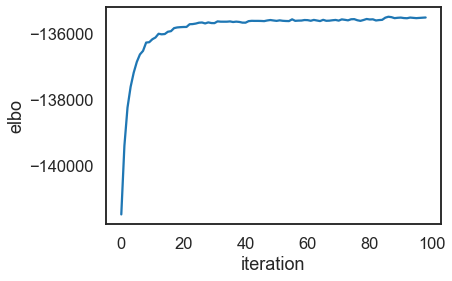

In [34]:
plt.plot(bounds[1:])
plt.xlabel("iteration")
plt.ylabel("elbo")

## Plot the inferred discrete states over iterations

Over the first few iterations, the states should change a fair amount.  Then they should stabilize.

Text(0, 0.5, 'vEM iteration')

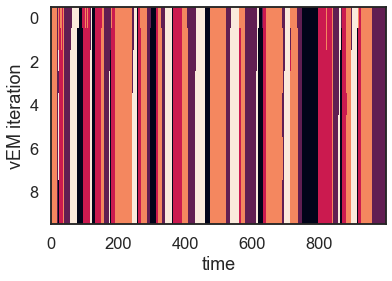

In [36]:
plt.figure(figsize=(6, 4))
plt.imshow(np.array(segmentations)[:10, :1000], aspect="auto", interpolation="none")
plt.xlabel("time")
plt.ylabel("vEM iteration")

## Compare the true and inferred discrete states

Text(0.5, 1.0, 'inferred state probabilities')

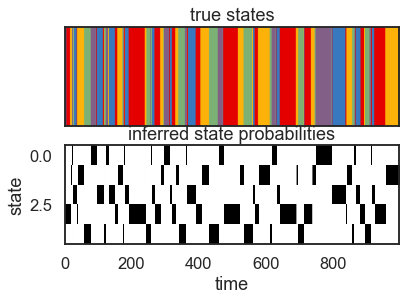

In [37]:
inferred_discrete_states = posterior.discrete_posterior.expected_states[0]

# Get the most likely discrete states
# NOTE: Should use the Viterbi algorithm instead!
most_likely_discrete_states = np.argmax(inferred_discrete_states, axis=-1)

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].imshow(true_states["discrete"][None, :1000], aspect="auto", cmap=cmap)
axs[0].set_yticks([])
axs[0].set_title("true states")

axs[1].imshow(inferred_discrete_states[:1000, :].T, aspect="auto", cmap="Greys", interpolation="none")
axs[1].set_ylabel("state")
axs[1].set_xlabel("time")
axs[1].set_title("inferred state probabilities")

## Plot the inferred continuous states

Hopefully we recovered the starfish dynamics of the latent states.

_Note: the SLDS latent states are invariant to invertible linear transformations, so the scale of the inferred states should not necessarily match that of the true latent states._

Text(0, 0.5, '$x_2$')

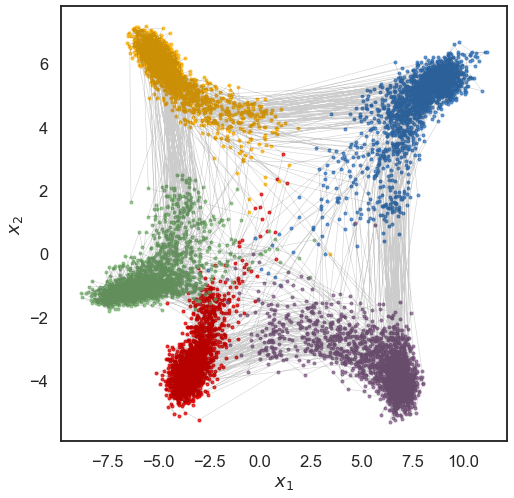

In [38]:
inferred_continuous_states = posterior.continuous_posterior.expected_states[0]

fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*inferred_continuous_states[most_likely_discrete_states==k].T, 
             'o', color=colors[k], alpha=0.75, markersize=3)
    
plt.plot(*inferred_continuous_states.T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")